# Query a topo/bathymetry DEM

Read in a topo/bathymetry DEM, plot the data, and provide interactive tools for querying the value at a single point or to produce a cross-section along a transect specified.

Note that the `%matplotlib notebook` command makes plots interactive. This is required for the callbacks used in this notebook.  It also means you can zooom in on plots.   Click on the blue off button at top of a figure when done interacting with it, or later plot commands will be sent to this figure.

This notebook uses tools from GeoClaw, which you may have to install.  See:
  https://github.com/rjleveque/geohack-2016/wiki/Installing-GeoClaw

In [1]:
%pylab inline
%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


## Fetch a topo DEM from the etopo1 database 

See:
    http://www.ngdc.noaa.gov/mgg/global/global.html

The etopo1 data has 1-arcminute resolution, but you can request coarsening.
E.g. set resolution = 4./60. for 4-arcminute resolution.

In [12]:
from clawpack.geoclaw import etopotools

xlimits = (-126,-122)
ylimits = (46,49)
resolution = 1./60.   # in degrees

etopotools.etopo1_download(xlimits,ylimits, dx=resolution, \
        output_dir='../DataFiles', verbose=True)

Done downloading.
Shifted xllcorner and yllcorner to cell centers
   and added nodata_value line
Created file:  ../DataFiles/etopo1_-126_-122_46_49_1min.asc


### Now read in this topo file, or another one that already exists:

(see http://www.clawpack.org/topo.html for information about different `topo_type`s)

In [13]:
from clawpack.geoclaw import topotools
topo = topotools.Topography()
topo.read('../DataFiles/etopo1_-126_-122_46_49_1min.asc', topo_type=3)

## Plot the topography

Note that because of the `%matplotlib notebook` command above, you can interact with this plot, e.g. zoom in.

Close the figure when you are done (the blue 0/1 button in the top right corner).

<IPython.core.display.Javascript object>


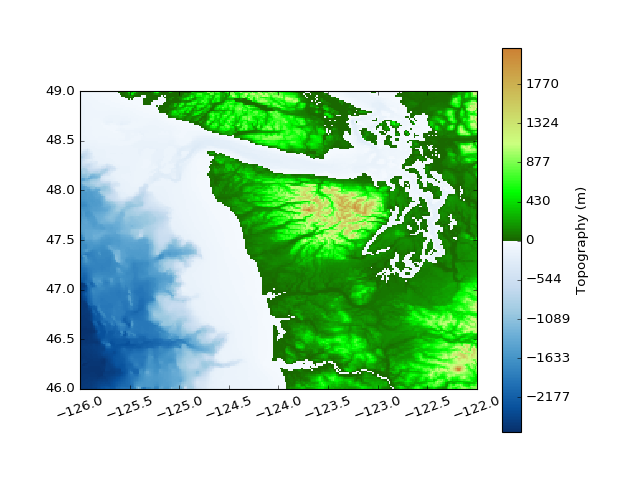

In [14]:
topo.plot()

## Define functions to interpolate to any point:

In [5]:
from scipy.interpolate import RegularGridInterpolator

X,Y = topo.X, topo.Y  # grid
B = topo.Z
topo_func = RegularGridInterpolator((X[0,:], Y[:,0]), B.T)

## Interactive plot to query topo at a single point

<IPython.core.display.Javascript object>


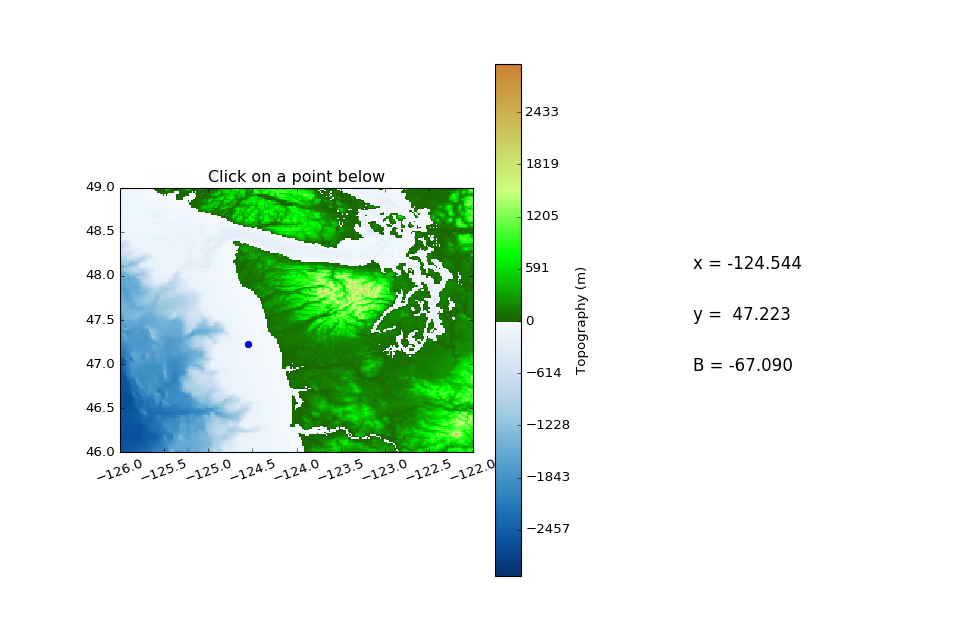

In [11]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(1,10) # set up placement of subplots
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(gs[0:,0:6])
ax2 = plt.subplot(gs[0:,7:])

x_ave = X.mean()
y_ave = Y.mean()  # for scaling by latitude

topo_limits = (-3000,3000)
topo.plot(limits=topo_limits,axes=ax1)

point = ax1.plot([x_ave],[y_ave],'bo')  # plot a point at the center to start

ax1.set_title("Click on a point below")

#ax2 = subplot(122)
axis([0,5,0,1])
axis('off')
xpt = x_ave
ypt = y_ave
Bpt = topo_func([xpt,ypt])
text_x = text(1,0.6,'x = %7.3f' % xpt, fontsize=15)
text_y = text(1,0.5,'y = %7.3f' % ypt, fontsize=15)
text_B = text(1,0.4,'B = %7.3f' % Bpt, fontsize=15)
      
def onclick(event):
    xpt = event.xdata
    ypt = event.ydata
    Bpt = topo_func([[xpt,ypt]])
    point[0].set_data([[xpt],[ypt]])
    text_B.set_text('B = %7.3f' % Bpt)
    text_x.set_text('x = %7.3f' % xpt)
    text_y.set_text('y = %7.3f' % ypt)
    draw()
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

## Interactive plot to select a transect

The next cell defines the DrawLine class:

In [7]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

class DrawLine:
    def __init__(self, line,topo):
        self.line = line
        self.figure = line[0].figure
        self.xprev = 0
        self.yprev = 0
        self.xnew = 0
        self.ynew = 0
        self.press = None
        self.topo = topo

    def connect(self):
        'connect to all the events we need'
        self.cidpress = self.figure.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.figure.canvas.mpl_connect(
            'button_release_event', self.on_release)

    def on_press(self, event):
        self.xprev = event.xdata
        self.yprev = event.ydata
        self.press = 1
        ax1.plot(self.xprev,self.yprev,'ro')
        self.figure.canvas.draw()
       
    def on_release(self, event):
        self.press = None
        self.xnew = event.xdata
        self.ynew = event.ydata
        
        ax1.cla()
        topo.plot(limits=topo_limits,axes=ax1,add_colorbar=False)
        
        ax1.plot(self.xprev,self.yprev,'ro')
        ax1.plot([self.xprev,self.xnew],[self.yprev,self.ynew],'-r',lw=3)
        ax1.plot(self.xnew,self.ynew,'ro')
        
        self.plot_transect()
        self.figure.canvas.draw()

    def disconnect(self):
        'disconnect all the stored connection ids'
        self.figure.canvas.mpl_disconnect(self.cidpress)
        self.figure.canvas.mpl_disconnect(self.cidrelease)
        
    def plot_transect(self):
        # points on transect:
        xi = linspace(self.xprev, self.xnew, 1000)
        yi = linspace(self.yprev, self.ynew, 1000)
        
        # evaulate topo on transect:
        Bi = self.topo(zip(xi,yi))
        
        # Clear axis 2
        ax2.cla()
    
        # plot vs. longitude or latitude depending on orientation:
        if (abs(self.xnew-self.xprev) > 0.5*abs(self.ynew-self.yprev)):
            ti = xi
            ax2.set_xlim(min(self.xprev,self.xnew),max(self.xprev,self.xnew))
            xtext = 'longitude'
        else:
            ti = yi
            ax2.set_xlim(min(self.yprev,self.ynew),max(self.yprev,self.ynew))
            xtext = 'latitude'
            
        Bi0 = where(Bi<0, 0., Bi)
        Bi_neg = where(Bi<0, Bi, 0.)
        
        ax2.fill_between(ti, Bi_neg, 0., color=[.5,.5,1])
        ax2.plot(ti, Bi, 'g', lw=2)
        
        ax2.set_xlabel(xtext)
        ax2.set_ylabel('meters')
        ax2.set_title('Topography vs. %s' % xtext)
    
        # choose limits of vertical axis to give nice plots:
        ax2.set_ylim(min(-6,Bi.min()*1.05), max(6,Bi.max()*1.05))
        ax2.grid(True)
    
        ax2.ticklabel_format(format='plain',useOffset=False)
        ax1.set_title('(%8.4f,%8.4f) to (%8.4f,%8.4f)' % (self.xprev,self.yprev,self.xnew,self.ynew))

### Try it out:

Note: zooming does not work on this plot!

Click a point on the map, drag, and release


<IPython.core.display.Javascript object>


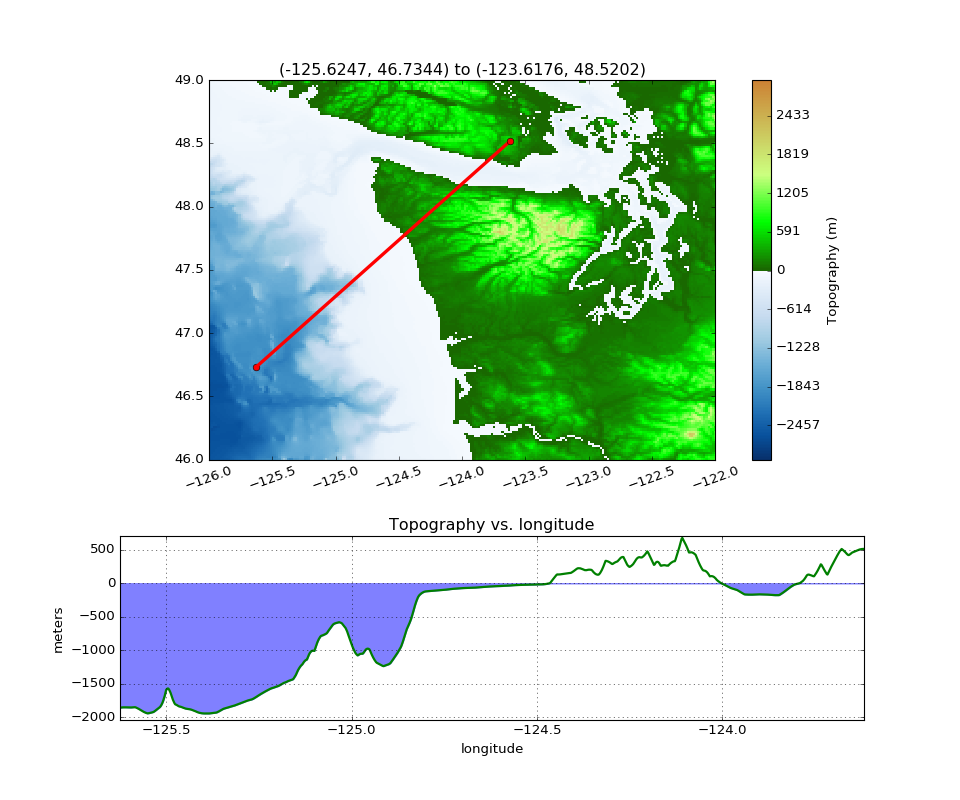

In [10]:
print("Click a point on the map, drag, and release")

gs = gridspec.GridSpec(10, 3)
fig = plt.figure(figsize=(12,10))
ax1 = plt.subplot(gs[0:6,0:])
ax2 = plt.subplot(gs[7:,0:])

topo.plot(limits=topo_limits,axes=ax1)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_title("Click a point, drag, and release")

points = ax1.plot([1],[10], '-k', lw=3)
dr =  DrawLine(points,topo_func)
dr.connect()

In [9]:
close('all')